In [1]:
import numpy as np

In [2]:
import pandas as pd
import pickle

In [3]:
usd = pd.read_csv('USD_RUB_60m.txt')
brent = pd.read_csv('BRENT_60m.txt')
american_finance = pd.read_csv('AMERICAN_FINANCE_60m.txt')
rtsi = pd.read_csv('RTSI_60m.txt')

In [4]:
rtsi_ds = rtsi[['<DATE>','<TIME>','<RTSI_HIGH>','<RTSI_LOW>']]
usd_ds = usd[['<DATE>','<TIME>','<USD_HIGH>','<USD_LOW>']]
brent_ds = brent[['<DATE>','<TIME>','<BRENT_HIGH>','<BRENT_LOW>']]
american_finance_ds = american_finance[['<DATE>','<TIME>','<AF_HIGH>','<AF_LOW>']]

In [5]:
total_ds = pd.merge(left = usd_ds, right = brent_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [6]:
total_ds = total_ds.merge(american_finance_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how = 'outer')

In [7]:
total_ds = total_ds.merge(rtsi_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [8]:
import datetime

In [9]:
total_ds['<WEEK_DAY>'] = list(map(lambda x: (datetime.datetime.strptime(str(x),'%Y%m%d').isoweekday()),total_ds['<DATE>']))

In [10]:
total_ds['<WEEK_NUM>'] = list(map(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').isocalendar()[1], total_ds['<DATE>']))

In [11]:
total_ds['<HOUR>'] = list(map(lambda x: int(x / 10000), total_ds['<TIME>']))

In [12]:
total_ds['<MONTH>'] = list(map(lambda x: int(str(x)[4:6]), total_ds['<DATE>']))

In [13]:
del total_ds['<DATE>']
del total_ds['<TIME>']

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class FillingFreeCellsLastValue(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for column in self.column_names:
            list_ = X[column]
            list_ = np.nan_to_num(list_, nan = 0)
            tmp_val = np.median(list_[:100])
            for num,element in enumerate(list_):
                if element > 0:
                    tmp_val = element
                else:
                    list_[num] = tmp_val
            X[column] = list_
        return X

In [16]:
columns = ['<USD_HIGH>', '<USD_LOW>', 
           '<BRENT_HIGH>', '<BRENT_LOW>',
           '<AF_HIGH>', '<AF_LOW>',
           '<RTSI_HIGH>', '<RTSI_LOW>']

In [17]:
FillingFreeCellsLastValue(columns).fit_transform(total_ds)

,<USD_HIGH>,<USD_LOW>,<BRENT_HIGH>,<BRENT_LOW>,<AF_HIGH>,<AF_LOW>,<RTSI_HIGH>,<RTSI_LOW>,<WEEK_DAY>,<WEEK_NUM>,<HOUR>,<MONTH>
0,63.6750,63.6750,48.955,48.765,249.597468,249.279047,0.00,0.00,7,44,23,11
1,64.0934,62.3727,48.955,48.765,249.597468,249.279047,0.00,0.00,1,45,0,11
2,64.5614,64.0450,48.955,48.765,246.563256,246.542204,0.00,0.00,1,45,1,11
3,64.5622,63.5524,48.955,48.765,246.568520,246.542204,0.00,0.00,1,45,2,11
4,64.5603,62.6139,49.500,49.370,246.568520,246.557993,0.00,0.00,1,45,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
28552,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.29,1065.60,6,52,17,12
28553,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.37,1066.87,6,52,18,12
28554,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1068.72,1066.11,6,52,19,12
28555,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1547.20,1544.07,3,52,18,12


In [18]:
total_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28557 entries, 0 to 28556
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <USD_HIGH>    28557 non-null  float64
 1   <USD_LOW>     28557 non-null  float64
 2   <BRENT_HIGH>  28557 non-null  float64
 3   <BRENT_LOW>   28557 non-null  float64
 4   <AF_HIGH>     28557 non-null  float64
 5   <AF_LOW>      28557 non-null  float64
 6   <RTSI_HIGH>   28557 non-null  float64
 7   <RTSI_LOW>    28557 non-null  float64
 8   <WEEK_DAY>    28557 non-null  int64  
 9   <WEEK_NUM>    28557 non-null  int64  
 10  <HOUR>        28557 non-null  int64  
 11  <MONTH>       28557 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 2.8 MB


In [99]:
train_data = np.array(total_ds)

ds_x = []
ds_y = []
days_hist= 30
days_predict = 5
hours_in_day = 24
num_history_values = hours_in_day * days_hist
num_predicted_value = hours_in_day * days_predict


for num, line in enumerate(train_data[:-(num_history_values+num_predicted_value)]):
    ds_x.append(train_data[num:num+num_history_values].reshape((train_data[num:num+num_history_values].size)))
for line in train_data[num_history_values+num_predicted_value:]:
    ds_y.append(line[0])

In [100]:
ds_x = np.asarray(ds_x, dtype = np.float16)
ds_y = np.asarray(ds_y, dtype = np.float16).reshape(-1,1)

In [101]:
idx = np.array(range(len(ds_y)))

In [102]:
np.random.shuffle(idx)

In [103]:
ds_x = ds_x[idx]
ds_y = ds_y[idx]

In [104]:
ds_x.shape

(27717, 8640)

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
ds_x_train, ds_x_test, ds_y_train, ds_y_test =  train_test_split(ds_x, ds_y, test_size = 0.2, random_state = 42)

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor

In [28]:
linreg = LinearRegression(n_jobs = -1)
dtreg = DecisionTreeRegressor(max_depth = 100)
knreg = KNeighborsRegressor(n_neighbors=10, n_jobs = -1)
rfr = RandomForestRegressor(n_estimators=20, max_depth=40, n_jobs = -1)
mlpreg = MLPRegressor()

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
estimators = [linreg, dtreg, knreg, rfr, mlpreg]
names = []
scores = []
for estimator in estimators:
    names.append(str(estimator).split(sep = '(')[0])
    estimator.fit(ds_x_train,ds_y_train)
    scores.append(mean_squared_error(ds_y_train, estimator.predict(ds_x_train), squared = False))
    print('finish',str(estimator).split(sep = '(')[0])

finish LinearRegression
finish DecisionTreeRegressor
finish KNeighborsRegressor


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


finish RandomForestRegressor


C:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


finish MLPRegressor


In [31]:
for name,score in zip(names,scores):
    print(name,score)

LinearRegression 0.81239223
DecisionTreeRegressor 0.0
KNeighborsRegressor 0.1951
RandomForestRegressor 0.06840592896863298
MLPRegressor 1.3824468270387607


In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
print(min(cross_val_score(linreg, ds_x_train, ds_y_train, cv=10, scoring='r2', n_jobs = -1)))

0.7060490537301616


In [34]:
print(min(cross_val_score(knreg, ds_x_train[:40000], ds_y_train[:40000], cv=5, scoring='r2', n_jobs = -1)))

0.994713935672962


In [35]:
print(min(cross_val_score(dtreg, ds_x_train[:40000], ds_y_train[:40000], cv=5, scoring='r2', n_jobs = -1)))

0.9954493146319627


In [36]:
print(min(cross_val_score(rfr, ds_x_train[:40000], ds_y_train[:40000], cv=5, scoring='r2', n_jobs = -1)))

0.9983601617293658


In [37]:
knreg.fit(ds_x_train,ds_y_train)
predicted_values_knreg = knreg.predict(ds_x_test)

In [42]:
filename = 'finalized_model_kneighbours_regressor.sav'
pickle.dump(knreg, open(filename, 'wb'))

In [38]:
dtreg.fit(ds_x_train,ds_y_train)
predicted_values_dtreg = dtreg.predict(ds_x_test)

In [43]:
filename = 'finalized_model_dec_tree_regressor.sav'
pickle.dump(dtreg, open(filename, 'wb'))

In [39]:
mlpreg.fit(ds_x_train,ds_y_train)
predicted_values_mlp = mlpreg.predict(ds_x_test)

C:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
filename = 'finalized_model_mlp_regressor.sav'
pickle.dump(mlpreg, open(filename, 'wb'))

In [40]:
rfr.fit(ds_x_train,ds_y_train)
predicted_values_rfr = rfr.predict(ds_x_test)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [45]:
filename = 'finalized_model_rend_forest_regressor.sav'
pickle.dump(rfr, open(filename, 'wb'))

kneighbours predictions - blue,
decision tree prediction - green

In [46]:
import matplotlib.pyplot as plt

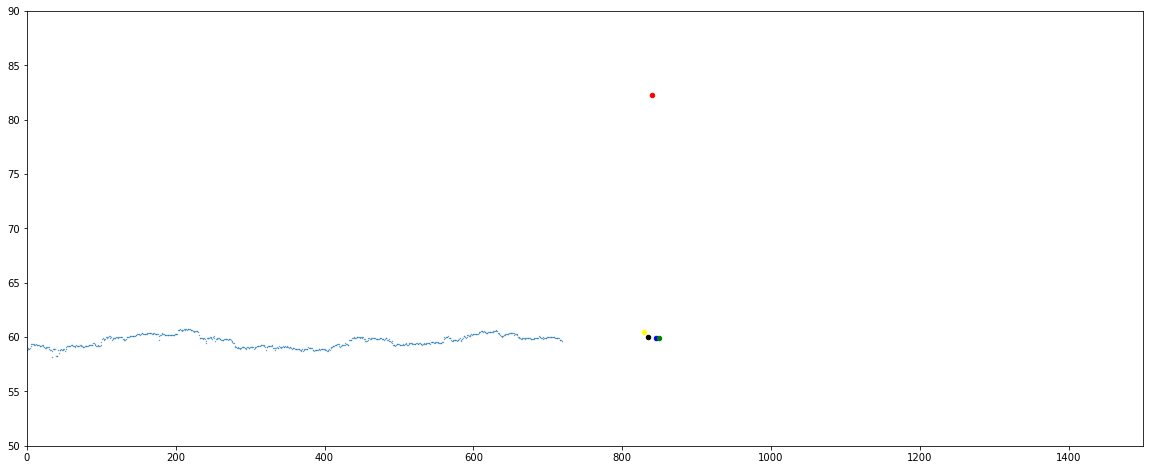

In [86]:
number = 2006
combination = ds_x_test[number].reshape(num_history_values,-1)[:,1]
length = len(combination)
plt.figure(figsize=(20,8))
plt.ylim(50,90)
plt.xlim(0,1500)
plt.scatter(range(length),combination,s=0.1)
shift = num_predicted_value
plt.scatter(shift+length, ds_y_train[number],s=20, color = 'red')
plt.scatter(shift+length+5, predicted_values_knreg[number],s=20, color = 'blue')
plt.scatter(shift+length+10, predicted_values_dtreg[number],s=20, color = 'green')
plt.scatter(shift+length-10, predicted_values_mlp[number],s=20, color = 'yellow')
plt.scatter(shift+length-5, predicted_values_rfr[number],s=20, color = 'black')

In [61]:
length+num_predicted_value

720

In [58]:
ds_x_test[1].reshape(num_history_values,-1)[:,1]

array([62.84, 62.84, 62.8 , 62.75, 62.75, 62.8 , 62.72, 62.84, 62.84,
       62.78, 62.66, 62.62, 62.62, 62.66, 62.53, 62.6 , 62.56, 62.53,
       62.62, 62.66, 62.72, 62.6 , 62.6 , 62.62, 62.66, 62.7 , 62.72,
       62.7 , 62.75, 62.75, 62.8 , 62.8 , 62.8 , 62.75, 62.9 , 62.8 ,
       62.84, 62.8 , 62.9 , 62.94, 62.97, 62.97, 62.97, 62.94, 62.97,
       63.  , 62.94, 62.94, 63.06, 62.97, 63.06, 63.1 , 63.16, 63.25,
       63.38, 63.38, 63.4 , 63.4 , 63.34, 63.38, 63.4 , 63.38, 63.38,
       63.34, 63.34, 63.38, 63.34, 63.34, 63.1 , 63.12, 63.1 , 63.16,
       63.12, 63.1 , 63.03, 63.06, 63.12, 63.12, 63.12, 63.16, 63.16,
       63.12, 63.03, 63.1 , 63.12, 63.12, 63.12, 63.  , 63.  , 63.03,
       63.1 , 63.06, 62.94, 62.94, 63.16, 63.2 , 63.16, 63.2 , 63.22,
       63.2 , 63.2 , 63.2 , 63.22, 63.2 , 63.22, 63.16, 63.16, 63.25,
       63.3 , 63.3 , 63.3 , 63.3 , 63.3 , 63.28, 63.22, 63.16, 63.1 ,
       63.06, 63.2 , 63.12, 63.12, 62.97, 62.88, 62.97, 63.  , 62.97,
       63.  , 63.  ,